In [1]:
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from kmv import KMV
from volatility import Volatility
from dataloader import Dataloader

project_root = Path("..")
sns.set(rc={"font.family": "SimHei", "axes.unicode_minus": False}, style="white")


model = KMV()
dd = model.distance_to_default()
st = pd.read_excel(
    project_root / "data/sts.xlsx", usecols=["stock", "name", "date", "enddate"]
)
dd.mean(axis=1)

日期
2008-06-30    0.996345
2008-12-31    1.593756
2009-06-30    2.479833
2009-12-31    3.403299
2010-06-30    3.090801
2010-12-31    4.299113
2011-06-30    3.989534
dtype: float64

## ST vs non-ST


<AxesSubplot: xlabel='日期'>

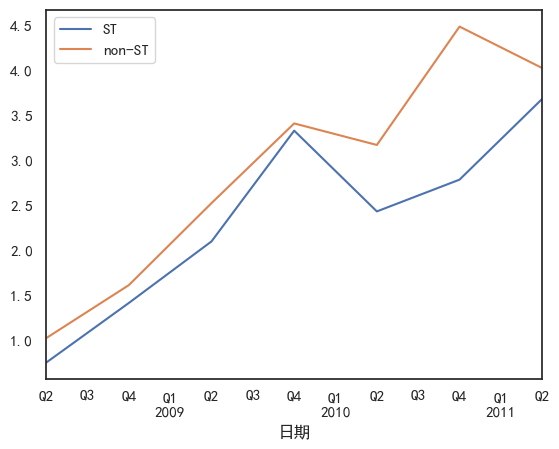

In [2]:
result = {"ST": [], "non-ST": []}
# for company in dd:
#     if model.label[company] in st["stock"].values:
#         date, enddate = st[st["stock"] == model.label[company]][
#             ["date", "enddate"]
#         ].values[0]
#         # result["ST"].append(dd[(dd.index > date) & (dd.index < enddate)][company])
#         result["ST"].append(dd[company])
#         if not dd[(dd.index > date) | (dd.index < enddate)].empty:
#             result["non-ST"].append(
#                 # dd[(dd.index > date) | (dd.index < enddate)][company]
#                 dd[company]
#             )
#     else:
#         result["non-ST"].append(dd[company])
for company in dd:
    if "ST" in company:
        result["ST"].append(dd[company])
    else:
        result["non-ST"].append(dd[company])
result = {i: pd.DataFrame(result[i]) for i in result}
pd.DataFrame({i: result[i].mean() for i in result}).plot()

In [3]:
ks_test = {}
for date in result["ST"].columns:
    ks_test[date] = {
        "statistic": (
            tmp := stats.ks_2samp(
                result["ST"][date],
                result["non-ST"][date],
                method="asymp",
                alternative="greater",
            )
        ).statistic,
        "pvalue": tmp.pvalue,
    }
ks_test = pd.DataFrame(ks_test)
with open(project_root / "results/ks_test.tex", "w") as f:
    f.write(ks_test.to_latex())
ks_test

/var/folders/nd/_3lfc6dn11q3hd0b4cz17ypw0000gn/T/ipykernel_84786/3610005193.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(ks_test.to_latex())


,2008-06-30,2008-12-31,2009-06-30,2009-12-31,2010-06-30,2010-12-31,2011-06-30
statistic,0.277778,0.222222,0.222222,0.194444,0.291667,0.291667,0.208333
pvalue,0.236850,0.384915,0.384915,0.472853,0.206561,0.206561,0.427943


In [4]:
mw_test = {}
for date in result["ST"].columns:
    mw_test[date] = {
        "statistic": (
            tmp := stats.mannwhitneyu(
                result["ST"][date], result["non-ST"][date], method="asymptotic"
            )
        ).statistic,
        "pvalue": tmp.pvalue,
    }
mw_test = pd.DataFrame(mw_test)
with open(project_root / "results/mw_test.tex", "w") as f:
    f.write(mw_test.to_latex())
mw_test

/var/folders/nd/_3lfc6dn11q3hd0b4cz17ypw0000gn/T/ipykernel_84786/1466797349.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(mw_test.to_latex())


,2008-06-30,2008-12-31,2009-06-30,2009-12-31,2010-06-30,2010-12-31,2011-06-30
statistic,303.000000,303.000000,296.000000,329.000000,278.000000,231.000000,320.000000
pvalue,0.758029,0.758029,0.679412,0.946084,0.494123,0.164506,0.958053


In [5]:
with pd.ExcelFile(project_root / "data/KMV模型已知量汇总.xlsx") as f:
    assets = Dataloader("assets", f).data.T
assets = assets[assets.index.isin(dd.columns)]
pearsons = {}
for date in dd.T:
    pearsons[date] = {
        "pearsonr": (tmp := stats.pearsonr(dd.T[date], assets[date]))[0],
        "pvalue": tmp[1],
    }
pearsons = pd.DataFrame(pearsons)
with open(project_root / "results/pearsons.tex", "w") as f:
    f.write(pearsons.to_latex())
pearsons

/var/folders/nd/_3lfc6dn11q3hd0b4cz17ypw0000gn/T/ipykernel_84786/43613031.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(pearsons.to_latex())


,2008-06-30,2008-12-31,2009-06-30,2009-12-31,2010-06-30,2010-12-31,2011-06-30
pearsonr,-0.265334,-0.221167,-0.410335,-0.230768,-0.354095,-0.444828,-0.464128
pvalue,0.016667,0.047233,0.000142,0.038201,0.001182,0.000032,0.000013


In [6]:
volatility = Volatility().data
volatility = volatility[dd.columns]
pearsons_vol = {}
for date in dd.T:
    pearsons_vol[date] = {
        "pearsonr": (tmp := stats.pearsonr(dd.T[date], volatility.T[date]))[0],
        "pvalue": tmp[1],
    }
pearsons_vol = pd.DataFrame(pearsons_vol)
with open(project_root / "results/pearsons_vol.tex", "w") as f:
    f.write(pearsons_vol.to_latex())
pearsons_vol

/var/folders/nd/_3lfc6dn11q3hd0b4cz17ypw0000gn/T/ipykernel_84786/917214607.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(pearsons_vol.to_latex())


,2008-06-30,2008-12-31,2009-06-30,2009-12-31,2010-06-30,2010-12-31,2011-06-30
pearsonr,-0.023419,-0.312969,-0.254424,-0.184716,-0.249410,-0.121688,-0.327771
pvalue,0.835603,0.004444,0.021901,0.098770,0.024741,0.279166,0.002817
